# RNN Sentiment Analysis

Import Dependencies

In [42]:
%store -r initial_processing_df

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, SimpleRNN, Embedding, LSTM
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from tqdm import tqdm
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams
from collections import Counter


import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import random
import nltk
import re

np.random.seed(124)
tf.random.set_seed(124)

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nawid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nawid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Training Dataset Preprocessing

In [43]:
# Loading the data
df = pd.read_csv('../Examensarbete_DS21/rnn_hotel_training_data.csv', encoding='ISO-8859-1')
df.shape

(27330, 6)

In [44]:
# Let's have a look at our dataset
df.head()

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review
0,Apex London Wall Hotel,5,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012
1,Corinthia Hotel London,5,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016
2,The Savoy,5,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013
3,Rhodes Hotel,4,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",6/2/2012
4,The Savoy,5,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017


In [45]:
# We only need the review text and raiting
df = df[['Review Text', 'Review Rating']]
df

,Review Text,Review Rating
0,Siamo stati a Londra per un week end ed abbiam...,5
1,I had a pleasure of staying in this hotel for ...,5
2,A very lovely first visit to this iconic hotel...,5
3,3 of us stayed at the Rhodes Hotel for 4 night...,4
4,Form the moment we arrived until we left we ex...,5
...,...,...
27325,I come to London often but since I stayed in t...,5
27326,En cuarto que nos tocó no había toallas y habí...,3
27327,This is a quality quiet hotel located in an ex...,4
27328,"Väldigt vackra rum, tyvärr med en mycket höglj...",4


In [46]:
# Checking for null values.
df.isna().any()

Review Text      False
Review Rating    False
dtype: bool

## Positive Column

In [47]:
# If rating [1, 2, 3] = Negative and if rating [4, 5] = Positive
def ratings(rating):
    if rating>0 and rating<=3:
        return 0
    if rating>3 and rating<=5:
        return 1
    
df['Positive'] = df['Review Rating'].apply(ratings)
df.head()

,Review Text,Review Rating,Positive
0,Siamo stati a Londra per un week end ed abbiam...,5,1
1,I had a pleasure of staying in this hotel for ...,5,1
2,A very lovely first visit to this iconic hotel...,5,1
3,3 of us stayed at the Rhodes Hotel for 4 night...,4,1
4,Form the moment we arrived until we left we ex...,5,1


## Word Count Column

In [48]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word_count'] = df['Review Text'].apply(word_count)
df.head()

,Review Text,Review Rating,Positive,Word_count
0,Siamo stati a Londra per un week end ed abbiam...,5,1,171
1,I had a pleasure of staying in this hotel for ...,5,1,265
2,A very lovely first visit to this iconic hotel...,5,1,54
3,3 of us stayed at the Rhodes Hotel for 4 night...,4,1,75
4,Form the moment we arrived until we left we ex...,5,1,62


# NLTK

In [3]:
def preprocess_text(sen):
    '''Cleans up text data, leaving 2 or more char long non-stopwords containing A-Z & a-z only in lowercase'''

    sentence = sen.lower()
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Remove single characters that are not part of words with more than one character
    sentence = re.sub(r"\b[a-zA-Z]\b", '', sentence)
    
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = sentence.split()
    filtered_words = [word for word in words if not word in stop_words]
    
    return ' '.join(filtered_words)


# EDA

In [4]:
df.describe()

,Review Rating,Positive,Length,Word_count
count,27330.000000,27330.000000,27330.000000,27330.000000
mean,4.490999,0.890853,752.375960,128.819539
std,0.891704,0.311830,830.363147,128.600239
min,1.000000,0.000000,16.000000,1.000000
25%,4.000000,1.000000,317.000000,55.000000
50%,5.000000,1.000000,522.000000,91.000000
75%,5.000000,1.000000,890.000000,156.000000
max,5.000000,1.000000,32759.000000,5781.000000


## Count of Reviews by Stars

In [24]:
df['Review Rating'].value_counts()

Review Rating
5    18327
4     6020
3     1675
2      691
1      617
Name: count, dtype: int64

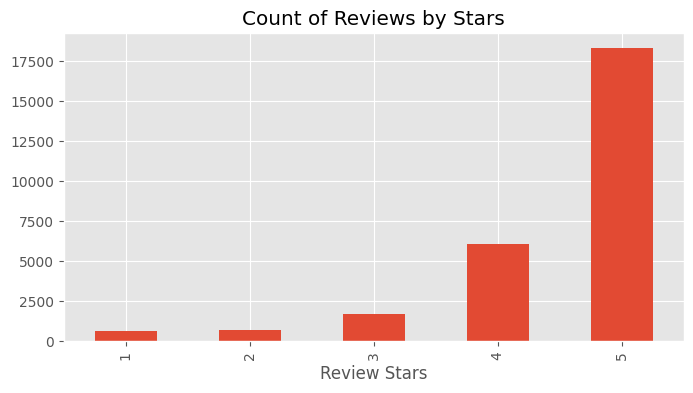

In [5]:
ax = df['Review Rating'].value_counts().sort_index().plot(
    kind='bar',
    title='Count of Reviews by Stars',
    figsize=(8, 4)
)
ax.set_xlabel('Review Stars')
plt.show()

The dataset consists of a significant number of positive reviews.

## Count of Reviews by Positive

In [25]:
df['Positive'].value_counts()

Positive
1    24347
0     2983
Name: count, dtype: int64

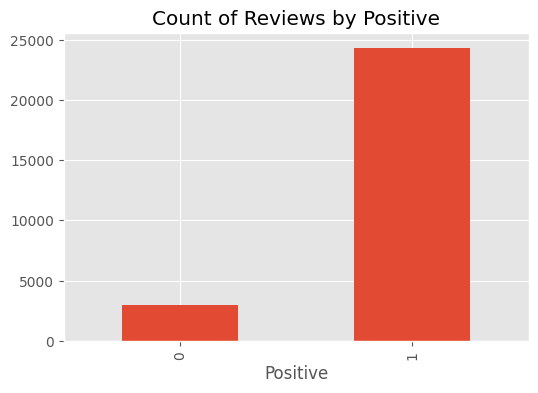

In [6]:
ax = df['Positive'].value_counts().sort_index().plot(
    kind='bar',
    title='Count of Reviews by Positive',
    figsize=(6, 4)
)
ax.set_xlabel('Positive')
plt.show()

The distribution of data is highly skewed towards positive reviews.

### Word Count by Review Rating

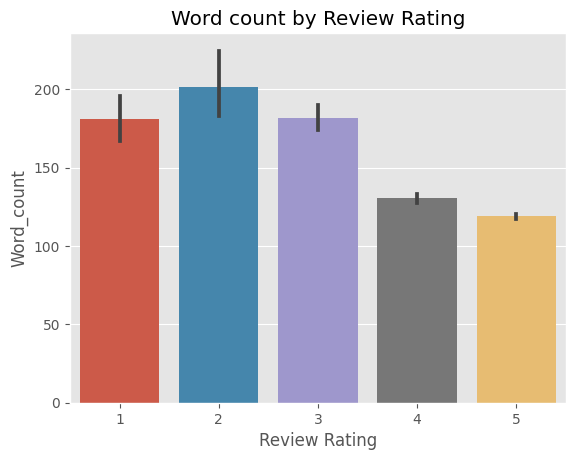

In [7]:
ax = sns.barplot(df, x='Review Rating', y='Word_count')
ax.set_title('Word count by Review Rating')
plt.show()

Based on the graph, it can be inferred that the number of words decreases as the star rating increases. This is not surprising, as people tend to have more to say when they are dissatisfied.

## Term Frequency

### Corpus
To analyze the most frequent words in the reviews, we will create a function called corpus(). This function will convert the review text into a list of words. However, before doing so, we need to clean the text using the preprocess_text function created earlier using the NLTK library. The cleaning process includes removing punctuations, numbers, single characters, multiple spaces, and stopwords.

In [8]:
# Empty list where the cleaned text will be stored
clean_text = []

clean_sentences = list(df['Review Text'])
for sen in tqdm(clean_sentences):
    clean_text.append(preprocess_text(sen))

100%|██████████| 27330/27330 [00:07<00:00, 3492.02it/s]


In [9]:
# A function that takes the review text and splits all the words
def corpus(text):
    test_list = text.split()
    return test_list

# Convert the clean_text list to a pandas Series object
clean_text_series = pd.Series(clean_text)

# Applies the corpus function on the review text and then saves into a new column
df['Corpus_Reviews'] = clean_text_series.apply(corpus)
df.head()

,Review Text,Review Rating,Positive,Length,Word_count,Corpus_Reviews
0,Siamo stati a Londra per un week end ed abbiam...,5,1,1063,171,"[siamo, stati, londra, per, un, week, end, ed,..."
1,I had a pleasure of staying in this hotel for ...,5,1,1425,265,"[pleasure, staying, hotel, nights, recently, h..."
2,A very lovely first visit to this iconic hotel...,5,1,324,54,"[lovely, first, visit, iconic, hotel, bar, won..."
3,3 of us stayed at the Rhodes Hotel for 4 night...,4,1,425,75,"[us, stayed, rhodes, hotel, nights, great, loc..."
4,Form the moment we arrived until we left we ex...,5,1,363,62,"[form, moment, arrived, left, experienced, abs..."


In [10]:
# Create an empty list to store all words in the corpus
all_words = []

# Iterate over each review in the corpus and add all words to the all_words list
for review in df['Corpus_Reviews']:
    all_words.extend(review)
    
# Count the frequency of each word and get the 10 most common words
word_freq = Counter(all_words)
top_words = word_freq.most_common(10)

# Print the 10 most common words
print("The 10 most frequent words in the corpus are:")
for word, freq in top_words:
    print(f"{word}: {freq}")

The 10 most frequent words in the corpus are:
hotel: 39554
room: 30251
staff: 18144
london: 15577
stay: 14150
service: 12920
great: 12509
breakfast: 11799
good: 10914
would: 10792


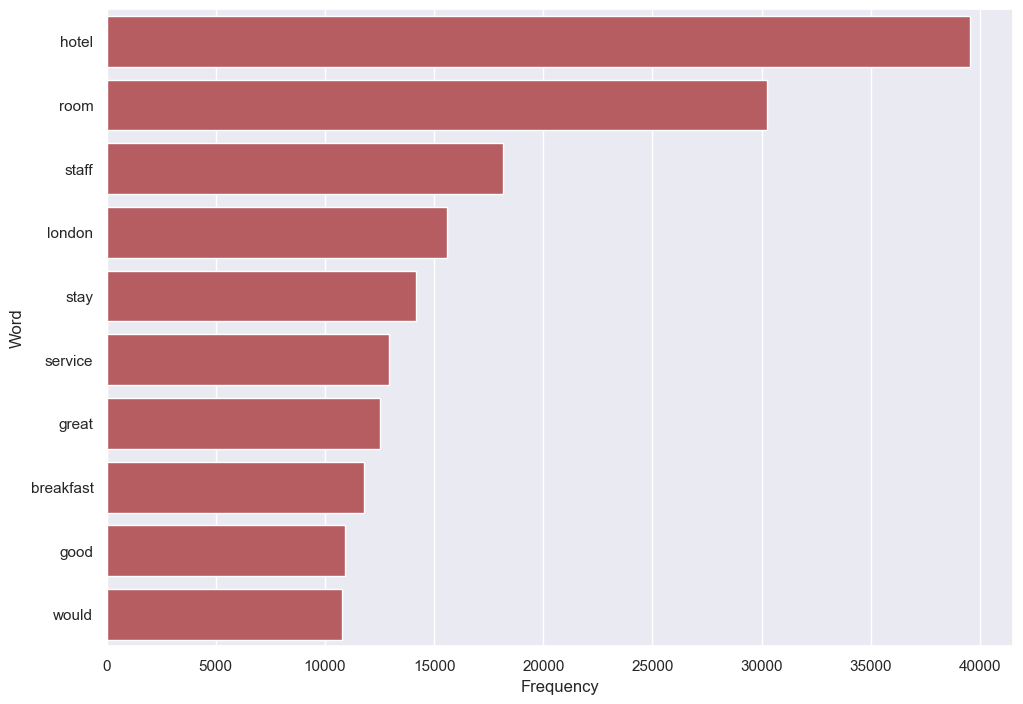

In [11]:
word_freq = Counter(all_words)
top_words = word_freq.most_common(10)

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_words], y=[val[0] for val in top_words], color='r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Word')
plt.show()

## Frequently occuring N_grams
Most frequently occurring n-grams
What is an n-gram? An n-gram is a sequence of n words in a text. Most words by themselves may not present the entire context. Typically, adverbs such as 'most' or 'very' are used to modify verbs and adjectives. Therefore, n-grams help analyze phrases and not just words, which can lead to better insights.

Some examples of n-grams are:

- bi-gram, which means two words in a sequence, such as 'very good' or 'too great'.
- tri-gram, which means three words in a sequence, such as 'how was your day'. This would be broken down to 'how was your' and 'was your day'.
- quad-gram, which means four words in a sequence.
- quint-gram, which means five words in a sequence.

### Bi-gram

In [27]:
# Create an empty list to store all bi-grams in the corpus
all_bigrams = []

# Iterate over each review in the corpus and add all bi-grams to the all_bigrams list
for review in df['Corpus_Reviews']:
    bigrams = ngrams(review, 2)
    all_bigrams.extend(list(bigrams))

# Count the frequency of each bi-gram and get the 10 most common bi-grams
bigram_freq = Counter(all_bigrams)
top_bigrams = bigram_freq.most_common(15)

# Print the 15 most common bi-grams
print("The 15 most frequent bi-grams in the corpus are:")
for bigram, freq in top_bigrams:
    print(f"{bigram}: {freq}")

The 10 most frequent bi-grams in the corpus are:
('afternoon', 'tea'): 1782
('staff', 'friendly'): 1660
('hyde', 'park'): 1608
('room', 'service'): 1480
('great', 'location'): 1378
('one', 'night'): 1355
('walking', 'distance'): 1234
('friendly', 'helpful'): 1228
('american', 'bar'): 1156
('would', 'definitely'): 1119
('tube', 'station'): 1062
('highly', 'recommend'): 1040
('recommend', 'hotel'): 1013
('hotel', 'staff'): 937
('front', 'desk'): 883


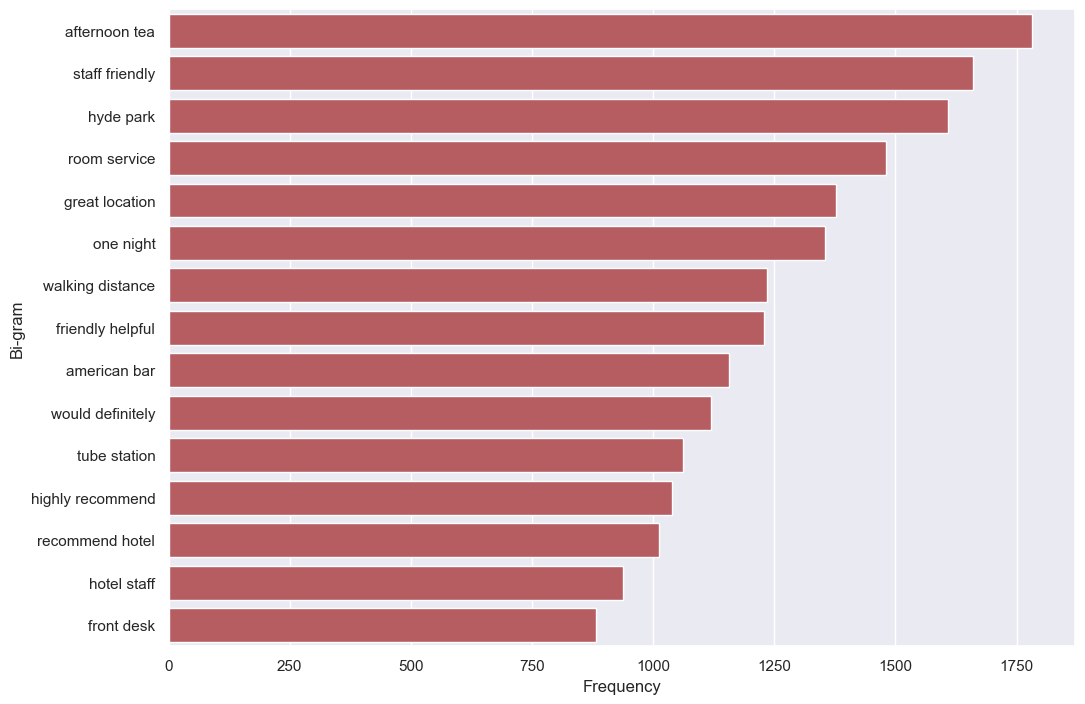

In [28]:
# Convert the tuples to strings
top_bigrams_str = [f"{bigram[0]} {bigram[1]}" for bigram, freq in top_bigrams]

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_bigrams], y=top_bigrams_str, color='r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Bi-gram')
plt.show()

### Tri-gram

In [29]:
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Create an empty list to store all tri-grams in the corpus
all_trigrams = []

# Iterate over each review in the corpus and add all tri-grams to the all_trigrams list
for review in df['Corpus_Reviews']:
    trigrams = ngrams(review, 3)
    all_trigrams.extend(list(trigrams))
    
# Count the frequency of each tri-gram and get the 10 most common tri-grams
trigram_freq = Counter(all_trigrams)
top_trigrams = trigram_freq.most_common(15)

# Print the 15 most common tri-grams
print("The 15 most frequent tri-grams in the corpus are:")
for trigram, freq in top_trigrams:
    print(f"{trigram}: {freq}")


The 10 most frequent tri-grams in the corpus are:
('staff', 'friendly', 'helpful'): 550
('nothing', 'much', 'trouble'): 505
('stayed', 'one', 'night'): 484
('within', 'walking', 'distance'): 458
('would', 'highly', 'recommend'): 444
('would', 'definitely', 'stay'): 440
('apex', 'london', 'wall'): 348
('hotel', 'great', 'location'): 340
('made', 'us', 'feel'): 325
('would', 'definitely', 'recommend'): 314
('south', 'kensington', 'tube'): 299
('highly', 'recommend', 'hotel'): 275
('victoria', 'albert', 'museum'): 269
('worth', 'every', 'penny'): 250
('would', 'recommend', 'hotel'): 248


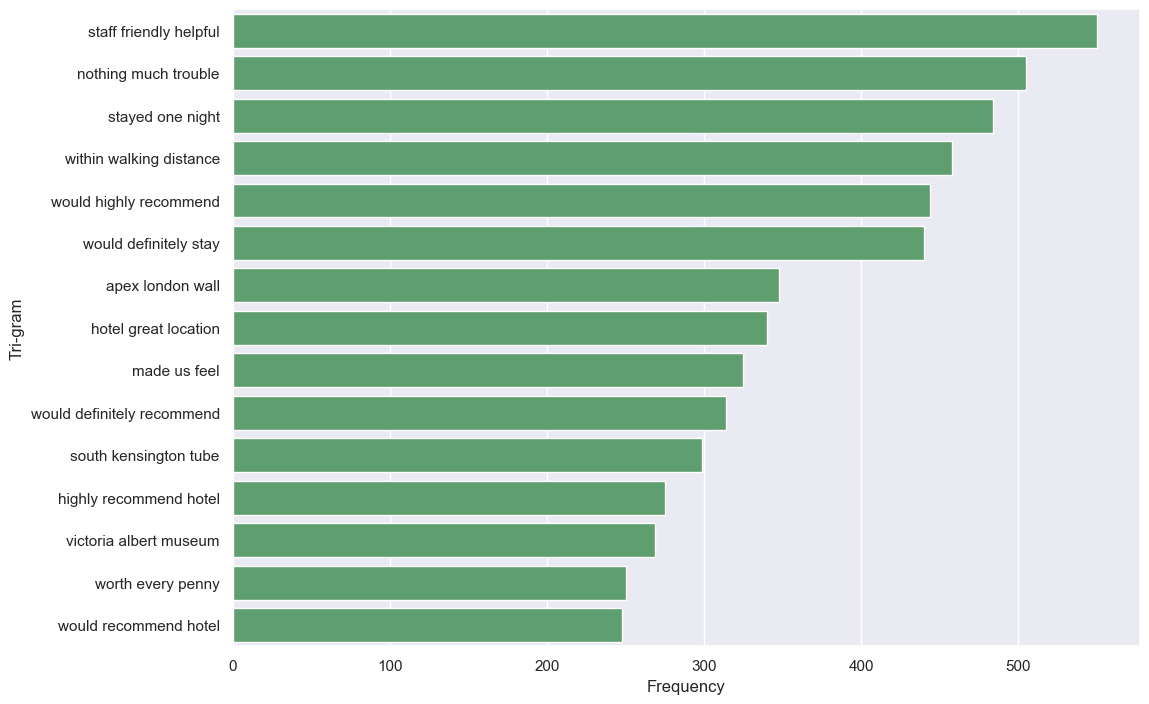

In [30]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_trigrams], y=[f"{val[0][0]} {val[0][1]} {val[0][2]}" for val in top_trigrams], color='g')
ax.set_xlabel('Frequency')
ax.set_ylabel('Tri-gram')
plt.show()

# Splitting Data to Train Test

In [ ]:
#TODO: Write comment here

x = []

sentences = list(df['Review Text'])
for sen in sentences:
    x.append(preprocess_text(sen))

In [ ]:
#x = df['Review Text']
x = np.array(x)
y = df['Positive']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print("shape of x_train:", x_train.shape)
print("shape of x_test:", x_test.shape)

print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)


# Prepering for model

It's apparent that the reviews vary in lengths, which is problematic. Neural networks cannot accept data of different lengths. Therefore, it is imperative that we standardize the length of each review. To accomplish this, we need to:

* Determine a fxied number of word.
* Tokenize the words.
* Pad the text.
* 

## Determine Number of Words

In [ ]:
# Checking mean and std
df["Word_count"].describe()

### Visual Inspection

Upon careful examination of both visuals, it becomes apparent that around 350 words represents the optimal maximum word count.

In [ ]:
sns.displot(df["Word_count"], height=8, aspect=1.5, bins=200)

In [ ]:
plt.figure(figsize=(6, 10))
sns.boxplot(df["Word_count"])
plt.show()

### IQR Method
To ensure accuracy, I will also use the IQR method to verify the validity or proximity of my observation.

In [ ]:
q1 = df["Word_count"].quantile(0.25)
q3 = df["Word_count"].quantile(0.75)
iqr = q3-q1

TODO: Check this comment

The upper limit, which is 307.5, closely aligns with my observation. Therefore, I will round it up to 350.

In [ ]:
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

upper_limit, lower_limit

## Tokenizing the text. Creates a word-to-index dictionary

Once a word is tokenized, the assigned number represents its frequency within the text. The number 1 corresponds to the most frequently occurring word, and so forth.

In [ ]:
# This is what the words look like before getting tokenized
print(x_train[4])
print(y_train[4])

In [ ]:
# Let's check what our vocabulary size is
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.copy())

VOCAB_SIZE = len(tokenizer.word_index)
print("Vocabulary size:", VOCAB_SIZE)

In [ ]:
VOCAB_SIZE = 52234

#, lower=True
tokenizer = Tokenizer(VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

# Providing each token an integer
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
# This is what the words look like after beeing tokenized
print(x_train[4])
print(y_train[4])

## Padding the text

* If a review exceeds 350 words, we will remove the excess words.
* If a review contains less than 350 words, we will append zeros to it until it reaches a length of 750 words.

In [ ]:
# Word lenghts before padding
len(x_train[0]), len(x_train[1]), len(x_train[2]), len(x_train[3]), len(x_train[4])

In [ ]:
# Max length of words
MAXLEN = 350

x_train = keras.utils.pad_sequences(x_train, padding='post', maxlen=MAXLEN)
x_test = keras.utils.pad_sequences(x_test, padding='post', maxlen=MAXLEN)

In [ ]:
# Word lenghts after padding
len(x_train[0]), len(x_train[1]), len(x_train[2]), len(x_train[3]), len(x_train[4])

In [ ]:
# And this is what it looks like if we take a closer look
x_train[4]

## One-Hot Encoding on y

In [ ]:
# The assigned number is dependent on the type of rating being used, which is currently set to 0 or 1 in this instance.
# However, it is possible to modify this.
num_classes = 2

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test[0])

## Resaping the data from 2D to 3D

Recurrent Neural Networks (RNNs) require 3D input because they are designed to operate on sequences of data. The 3D input tensor consists of a batch size, sequence length, and feature dimensions.

* Batch size: The number of sequences in a batch, typically represented as the first dimension of the 3D tensor.
* Sequence length: The number of time steps in each sequence, represented as the second dimension of the 3D tensor.
* Feature dimensions: The number of features or variables in each time step, represented as the third dimension of the 3D tensor.

The 3D input tensor allows RNNs to process a sequence of data over time, where each time step contains a set of features. By using a 3D input, RNNs can learn and remember patterns and dependencies across multiple time steps, which is useful in a variety of applications such as natural language processing, speech recognition, and time series forecasting.

In [ ]:
x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print("Sentences:", x_train.shape[0], "Words:", x_train.shape[1], "TimeSteps:", x_train.shape[2], "\n")
print(x_test.shape)
print("Sentences:", x_test.shape[0], "Words:", x_test.shape[1], "TimeSteps:", x_test.shape[2])

# Model Building

In [ ]:
# NN Model
model = tf.keras.Sequential([
tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=50, input_length=MAXLEN),
tf.keras.layers.LSTM(32, return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(16, return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation="sigmoid"),
])

model.summary()

## Weights

We are dealing with imbalanced data. It's important to adjust the weights of the classes to reflect their distribution. This can be done by calculating the class weights and passing them to the model during training.

The class weights can be calculated using various techniques such as inverse frequency, inverse square root frequency, or user-defined weights. Inverse frequency assigns a weight to each class that is inversely proportional to the number of samples in that class. Inverse square root frequency assigns a weight that is the inverse square root of the frequency of the class. User-defined weights allow the user to manually assign weights to each class based on their domain knowledge.

I opted for inverse frequency as you can seee below.

In [ ]:
# Frequency
freq = pd.value_counts(df['Positive'])
freq

In [ ]:
# Inverse frequency
weights = {0: freq.sum() / freq[0], 1: freq.sum() / freq[1]}
weights

## ModelCheckpoint

In [ ]:
# Creating checkpoint that saves the best model
checkpoint = ModelCheckpoint('model/', save_best_only=True)
#, monitor='val_accuracy', mode='max'

# Stop the training if the val_loss does not improve on next 4 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Creates a csv file and saves the model metrics in it
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

# A lsit with the 3 instances that will be put into callbacks in model.fit()
callback_lsit = [checkpoint, early_stop, log_csv]

## Training Model

In [ ]:
# Creating an instance of BinaryCrossentropy to pass into model.compile()
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Configure the model for training.
model.compile(optimizer=Adam(learning_rate=(0.0001)), loss=loss_fn, metrics=['accuracy', AUC(name='auc')])

# Train a model
history = model.fit(x_train, y_train, batch_size=150, epochs=20, validation_split=0.20, class_weight=weights, callbacks=[callback_lsit])

# Model Evaluation

Let's evaluate the model to see how well it did

In [ ]:
results = model.evaluate(x_test, y_test)

TODO: make this a comment instead with f string that gets the accuracy score and round it

So we're scoring somewhere in the high 80's. Not bad for a simple recurrent network.

The precision and recall for both classes are high, indicating that the model is able to correctly identify both positive and negative cases. The f1-score is also high for both classes, which suggests that the model has a good balance between precision and recall.

The macro and weighted average scores are also high, which indicates that the model is performing well overall.

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

best_model = load_model('model/')

test_predictions = (best_model.predict(x_test) > 0.5).astype(int)

print(classification_report(y_test, test_predictions))

In [ ]:
# Model Performance Chart

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

TODO: make this a comment instead with f string that gets the score and round it


Looking at this output, the accuracy score for the training set is around 89-90%, while the accuracy score for the validation set is around 90-91%. This suggests that the model is performing well and not overfitting too much to the training data. The loss scores are also decreasing with each epoch, which is a good sign that the model is learning from the data.


Great! The ROC AUC score of my model is 0.901998439517365 which indicates that my model is performing well. A value of 0.5 indicates random guessing, while a value of 1 indicates perfect performance. A score between 0.7 to 0.9 is considered good, while a score above 0.9 is considered excellent. Therefore, I would say my model is performing well in terms of its ability to distinguish between positive and negative samples.

### Confusion Mtrix

In [ ]:
# TODO Check comment.
# Get the predicted labels for the test set
#y_pred = model.predict(x_test)
#y_pred = (y_pred > 0.5)

# Create the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), test_predictions.argmax(axis=1))

print(cm)

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

TODO: make this a comment instead with f string that gets the score and rounds it


Based on the output, the confusion matrix has four values - true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP). The matrix is a 2x2 matrix, with the top row representing the actual negatives and the bottom row representing the actual positives. The left column represents the predicted negatives and the right column represents the predicted positives.

Here, the model predicted 321 true negatives and 4705 true positives. It also predicted 276 false positives and 164 false negatives.

# Making Predictions

Next, we will utilize our neural network to predict the sentiment of our own reviews. However, since the reviews are encoded, we need to convert our new reviews into the same encoding format so that the network can process them. To accomplish this, we will load the encodings from the existing dataset and apply them to our new data.

In [ ]:
data = initial_processing_df
data.head()

In [ ]:
# Preprocessing the new text with the process function I created earlier

unseen_reviews = data['Review']

#unseen_processed = []
#for review in unseen_reviews:
#    review = preprocess_text(review)
#    unseen_processed.append(review)

In [ ]:
# Tokenizing the text
unseen_tokenized = tokenizer.texts_to_sequences(unseen_reviews)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = keras.utils.pad_sequences(unseen_tokenized, padding='post', maxlen=MAXLEN)

In [ ]:
unseen_sentiments = model.predict(unseen_padded)

In [ ]:
res = {}

for i, row in data.iterrows(), total=len(data)):
    text = row['Review']
    myid = row['id']
    unseen_sentiments = model.predict(unseen_padded)
    